<h1 align="center">Tutorial: Bird by Bird using Finite Automata</h1>
<h2 align="center">Finite automata simulation for leveraging AI-assisted systems on object detection</h2>
<img src="../images/logo_part2.jpg">

## Background and motivation


This work is a part of the [Bird by Bird Tech](https://towardsdatascience.com/tagged/bird-by-bird-tech) series and is devoted to modelling and simulation of real-life systems for computer vision applications using finite automata. Here, we are going to create an FSM simulation replicating behavior of an AI-assisted security system for lawn monitoring and cleaning. In particular, we will tackle the task of simulating processes to intelligently manage the coming and going of birds through object detection and water sprinkling subsystems. In the [previous article](https://towardsdatascience.com/bird-by-bird-using-finite-automata-9d50b36bcbd3), you had been introduced to the theory and design principles on finite state machines (FSM) for dealing with the infamous Chicken-and-Turkey (CaT) problem, resulting in the creation of a model that describes complex lawn scenarios at a high level of abstraction. 

Through this tutorial, we will further investigate the topic of practical aspects of an FSM-based simulation for leveraging the real-life system operation and implement the FSM simulation in Python so that we can later improve it via optimization and XAI techniques. By the end of the tutorial, you'll have a fully functional FSM solution along with a better understanding of simulation modelling for solving engineering problems, such computer vision projects.

In [1]:
!pip install --q ipywidgets tqdm

In [2]:
# import packages
import os
import sys
import tqdm
import numpy as np
import pandas as pd
import ipywidgets as widgets

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

from src.yard_simulation.target import Target
from src.yard_simulation.simulation import YardSimulation

from typing import Generator, Optional, Tuple

## Defining experimental setup

In [3]:
# define input parameters for simulation
sim_start = widgets.IntSlider(value=6, min=0, max=12, description='start time [hr]')  # start of the day (6:00 AM by default)
sim_steps = widgets.IntSlider(value=12, min=1, max=24 - sim_start.value, description='duration [hr]')  # simulation steps (12 hours or daytime)
num_trials = widgets.IntText(value=100, description='num trials')  # simulation trials
random_seed = widgets.IntText(value=42, description='random seed')  # random seed

display(sim_start, sim_steps, random_seed, num_trials)

IntSlider(value=6, description='start time [hr]', max=12)

IntSlider(value=12, description='duration [hr]', max=18, min=1)

IntText(value=42, description='random seed')

IntText(value=100, description='num trials')

In [4]:
# define detection matrix for a baseline CV-based bird detector
detector_matrix = np.full((len(Target),) * 2, len(Target) ** -1)

print('Detection matrix baseline (non-trained):')
display(
    pd.DataFrame(
        detector_matrix,
        columns=[f'{n.lower()}_true' for n in Target._member_names_],
        index=[f'{n.lower()}_pred' for n in Target._member_names_]
    ).style.background_gradient(
        vmin=0,
        vmax=1,
        cmap='Blues'
    )
)

Detection matrix baseline (non-trained):


,chicken_true,turkey_true,empty_true
chicken_pred,0.333333,0.333333,0.333333
turkey_pred,0.333333,0.333333,0.333333
empty_pred,0.333333,0.333333,0.333333


## Simulation runs and assessment of state transitions

In [5]:
def run_simulation(
    detector_matrix: np.ndarray,
    num_steps: int,
    start_time: int,
    seed: Optional[int] = None,
) -> YardSimulation:
    """
    Run the FSM simulation and print state transitions that the FSM undergoes at every timestep.
    """

    # convert to mins for nice prints
    num_steps *= 60
    start_time *= 60

    
    # instantiate a simulation object
    sim = YardSimulation(
        detector_matrix=detector_matrix,
        num_steps=num_steps, seed=seed
    )
    
    # run simulation and print state transitions 
    for step_idx, states in sim.run():
        sod_adjusted = start_time + step_idx
        h = sod_adjusted // 60
        m = sod_adjusted - (h * 60)
        print(
            f'\t{h:0>2}:{m:0>2}: {" -> ".join(map(str, states))}'
        )

    return sim


# run simulation given input parameters
sim = run_simulation(
    detector_matrix=detector_matrix,
    num_steps=sim_steps.value,
    start_time=sim_start.value,
    seed=random_seed.value
)

	06:01: Spawn
	06:02: Intrusion -> NotDetected -> Attacking -> Attacked -> Spawn
	06:03: Intrusion -> Detected -> Sprinkling -> Hit -> Leaving -> Spawn
	06:04: Intrusion -> NotDetected -> Attacking -> NotAttacked -> Spawn
	06:05: Intrusion -> NotDetected -> Attacking -> Attacked -> Spawn
	06:06: Intrusion -> Detected -> Sprinkling -> Hit -> Leaving -> Spawn
	06:07: Intrusion -> Detected -> Sprinkling -> Hit -> Leaving -> Spawn
	06:08: Intrusion -> Detected -> Sprinkling -> Hit -> Leaving -> Spawn
	06:09: Intrusion -> Detected -> Sprinkling -> Miss -> Attacking -> Attacked -> Spawn
	06:10: Intrusion -> NotDetected -> Attacking -> Attacked -> Spawn
	06:11: Intrusion -> NotDetected -> Attacking -> Attacked -> Spawn
	06:12: Intrusion -> NotDetected -> Attacking -> NotAttacked -> Spawn
	06:13: Intrusion -> NotDetected -> Attacking -> NotAttacked -> Leaving -> Spawn
	06:14: Intrusion -> NotDetected -> Attacking -> NotAttacked -> Spawn
	06:15: Intrusion -> Detected -> Sprinkling -> Miss -> At

## Simulation output statistics tracking

In [6]:
def gather_statistics(
    detector_matrix: np.ndarray,
    num_steps: int,
    num_trials: int,
    hit_proba: float = 0.8
) -> Generator:
    """ 
    Return Counter generator for output water usage for target sprinkling and lawn cleaning across targets.
    Output example: 
       (Counter({<Target.CHICKEN: 0>: 600, <Target.TURKEY: 1>: 1106}),
        Counter({<Target.CHICKEN: 0>: 636, <Target.TURKEY: 1>: 1071})).
    """
    yield from zip(
        *map(
            lambda _, stats: stats,
            *zip(
                *map(
                    lambda sim: (
                        list(sim.run()),
                        (
                            sim.water_consumption,
                            sim.lawn_damage,
                        )
                    ),
                    (
                        YardSimulation(
                            detector_matrix=detector_matrix,
                            num_steps=num_steps,
                            hit_proba=hit_proba
                        )
                        for _ in tqdm.trange(
                            num_trials
                        )
                    )
                )
            )
        )
    )


def aggregate_statistics(
    detector_matrix: np.ndarray,
    num_steps: int,
    num_trials: int,
    hit_proba: float = 0.8
) -> np.ndarray:
    """
    Return aggregated-by-targets water usage for target sprinkling and lawn cleaning.
    Output example: [[1701 1646] [1798 1414]].
    """
    return np.array(
        list(
            zip(
                *map(
                    lambda *stats: map(lambda rs: sum(rs.values()), stats),
                    *gather_statistics(
                        detector_matrix=detector_matrix,
                        num_steps=num_steps,
                        num_trials=num_trials,
                        hit_proba=hit_proba
                    )
                )
            )
        )
    ).T

In [7]:
# compute simulation output statistics for the baseline detector 
water_usage_baseline = aggregate_statistics(
    detector_matrix,
    num_steps=sim_steps.value,
    num_trials=num_trials.value
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2095.19it/s]


In [8]:
# define detection matrix for a perfect CV-based detector
detector_matrix_perfect = np.eye(len(Target))

# compute simulation statistics for the perfect detector 
water_usage_perfect = aggregate_statistics(
    detector_matrix_perfect,
    num_steps=sim_steps.value,
    num_trials=num_trials.value
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1874.50it/s]


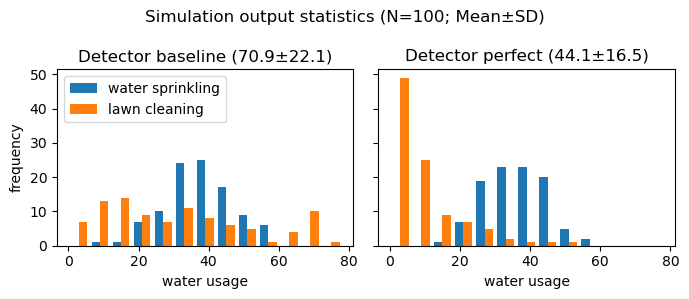

In [9]:
# compare simulation output statistics related to the water usage
total_usage_baseline = np.sum(water_usage_baseline, axis=1)
total_usage_perfect = np.sum(water_usage_perfect, axis=1)

water_base_mean, water_base_std = np.mean(total_usage_baseline), np.std(total_usage_baseline)
water_perfect_mean, water_perfect_std = np.mean(total_usage_perfect), np.std(total_usage_perfect)

# display distribution of the simulation statistics across experiments
fig, (a, b) = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
fig.suptitle(f'Simulation output statistics (N={num_trials.value}; Mean±SD)')

label=['water sprinkling', 'lawn cleaning']

bins = np.arange(0, 81, 6)
a.hist(water_usage_baseline, bins=bins, histtype='bar',label=label)
b.hist(water_usage_perfect, bins=bins, histtype='bar',label=label)
a.set_title('Detector baseline ({:.1f}±{:.1f})'.format(water_base_mean, water_base_std))
b.set_title('Detector perfect ({:.1f}±{:.1f})'.format(water_perfect_mean, water_perfect_std))
a.set_ylabel('frequency')

for ax in fig.axes:
    ax.set_xlabel('water usage')

a.legend(loc=2)
plt.tight_layout()
plt.show()

## Conclusions
To sum up, simulation modelling is a useful tool that can be used to estimate efficiency of processes, enable rapid testing of anticipated changes, and understand how to improve processes through operation and maintenance. Through this article, you have gained a better understanding on practical applications of simulation modelling for solving engineering problems. In particular, we've covered the following:

* How to design a model to approximate a complex system to improve its operation on bird detection and water sprinkling.
* How to create a simulation of real-world processes to understand the CaT-system behavior under various conditions.
* How to implement an FSM-based solution in Python for the system to track relevant statistics of the simulation.

## Outlook

Focusing on improving resource efficiency, in the follow-up articles, you will discover how to address a non-analytic optimization problem of the water cost reduction by applying Monte-Carlo and eXplainable AI (XAI) methods for leveraging the AI-assisted lawn security system on bird detection. What are other important concepts in simulation modelling and optimization for vision projects? Find out more on [Bird by Bird Tech](https://towardsdatascience.com/tagged/bird-by-bird-tech).
___

Except as otherwise noted, the content of the above materials is licensed under the Creative Commons Attribution Non Commercial 4.0 International, and code samples are licensed under the Apache 2.0 License.